In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib

from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
gpdm_save_name = "gpmdm"

In [3]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [4]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [5]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [6]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [7]:
for train_arr in walk_train_arrs[0:6]:
    gpdm.add_data(train_arr, 0)
for train_arr in run_train_arrs[0:6]:
    gpdm.add_data(train_arr, 1)

total_sequences = sum([len(L) for L in gpdm.class_aware_observations_list])
print(f"Total sequences: {total_sequences}")

Total sequences: 12



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.0708e+07
Update time: 0.28526902198791504

GPDM Opt. EPOCH: 10
Running loss: 3.5254e+06
Update time: 3.934648036956787

GPDM Opt. EPOCH: 20
Running loss: 1.4767e+06
Update time: 2.051370143890381

GPDM Opt. EPOCH: 30
Running loss: 6.7207e+05
Update time: 3.2537176609039307

GPDM Opt. EPOCH: 40
Running loss: 3.5661e+05
Update time: 2.3853113651275635

GPDM Opt. EPOCH: 50
Running loss: 2.1077e+05
Update time: 1.7033312320709229

GPDM Opt. EPOCH: 60
Running loss: 1.3082e+05
Update time: 1.7662675380706787

GPDM Opt. EPOCH: 70
Running loss: 9.5132e+04
Update time: 1.6814606189727783

GPDM Opt. EPOCH: 80
Running loss: 7.8480e+04
Update time: 1.7825665473937988

GPDM Opt. EPOCH: 90
Running loss: 6.8504e+04
Update time: 1.911372423171997

GPDM Opt. EPOCH: 100
Running loss: 6.1022e+04
Update time: 1.8018004894256592

GPDM Opt. EPOCH: 110
Running loss: 5.4743e+04
Update time: 1.6738076210021973

GPDM Opt. EPOCH: 120
Running loss

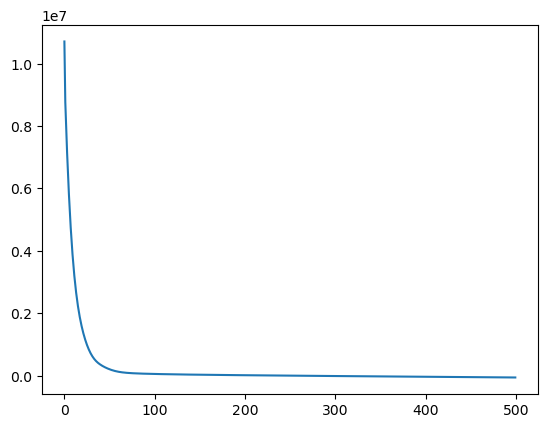

In [8]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=500, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

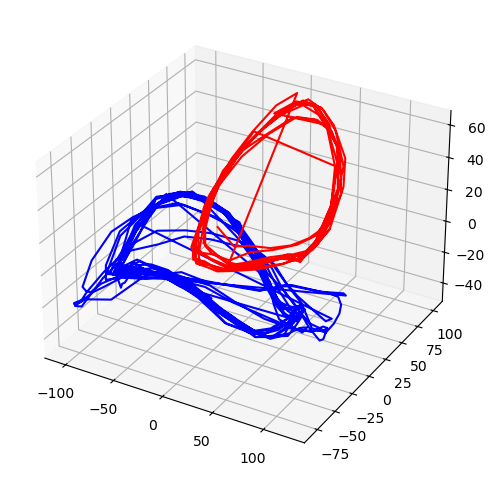

In [9]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()

In [10]:
gpdm.set_evaluation_mode()
_, _, _, latent_map_mse = gpdm.get_latent_map_performance()

print(f"Latent map MSE: {latent_map_mse}")

for i in range(gpdm.n_classes):
    _, _, _, _, dynamics_MSE = gpdm.get_dynamics_map_performance_for_class(i)
    print(f"Class {i} dynamics map MSE: {dynamics_MSE}")


Latent map MSE: 33.89359243697479
Class 0 dynamics map MSE: 2.0501253132832082
Class 1 dynamics map MSE: 8.414160401002507


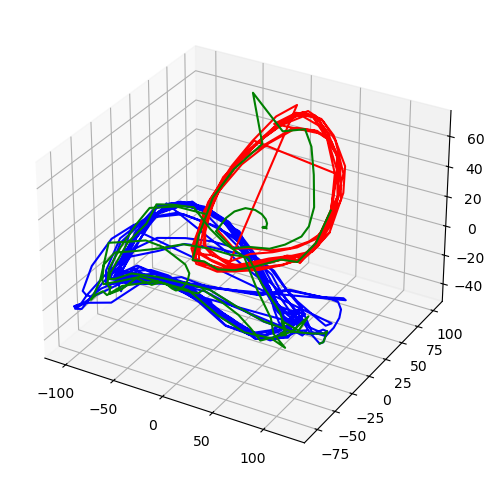

In [21]:
# For each class, pick a random point from the training latent space and generate a sequence

generated = []
for c in range(gpdm.n_classes):
    X0 = gpdm.get_X_for_class(c)
    X0_sample = X0[np.random.randint(X0.shape[0]), :]

    # Generate a sequence
    seq_len = 100
    X_generated = torch.zeros((seq_len, d))
    X_generated[0, :] = X0_sample
    for i in range(1, seq_len):
        X_generated[i, :], _ = gpdm.map_x_dynamics_for_class(X_generated[i-1, :].unsqueeze(0), c)

    generated.append(X_generated.detach().numpy())

# Plot the generated sequence in the latent space in green
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

for c in range(gpdm.n_classes):
    ax.plot(generated[c][:, 0], generated[c][:, 1], generated[c][:, 2], 'g')

    